In [65]:
import os
import datetime
import numpy as np
#import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline

%load_ext autoreload
%autoreload 2

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

_save_dir = 'plots/'

# colors = {
#     211: 'lightgreen',
#     2122: 'lightblue',
#     13: 'blue',
#     11: 'navy',
#     111: 'black'
# }

colors = ['black', 'navy', 'blue', 'lightblue', 'lightgreen',]

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
n_pions = 9511 * 30000
config = 'config07_2'

In [3]:
file = uproot.open(f)
print(file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 285330000
Number of spills: 1141.32
Number of hours: 19.022
Number of months: 0.026419444444444443


In [4]:
file[f'VirtualDetector/JGGDet1'].keys()

['x',
 'y',
 'z',
 'Px',
 'Py',
 'Pz',
 't',
 'PDGid',
 'EventID',
 'TrackID',
 'ParentID',
 'Weight']

In [9]:
f'Particles / {n_pions:.1e}' + r'$\pi$' + 'on target ({n_hours} hours of data)' 

'Particles / 2.9e+08$\\pi$on target ({n_hours} hours of data)'

In [6]:
# det = 8
# branches = [f'PxDet{det}', f'PyDet{det}', f'PzDet{det}', f'PDGidDet{det}', f'TrackPresentDet{det}']
# arrays = file[f'EventsDet{det}'].arrays(branches, entry_start=0, entry_stop=1)

In [7]:
file[f'VirtualDetector/JGGDet2'].num_entries
# file.keys()

33816545

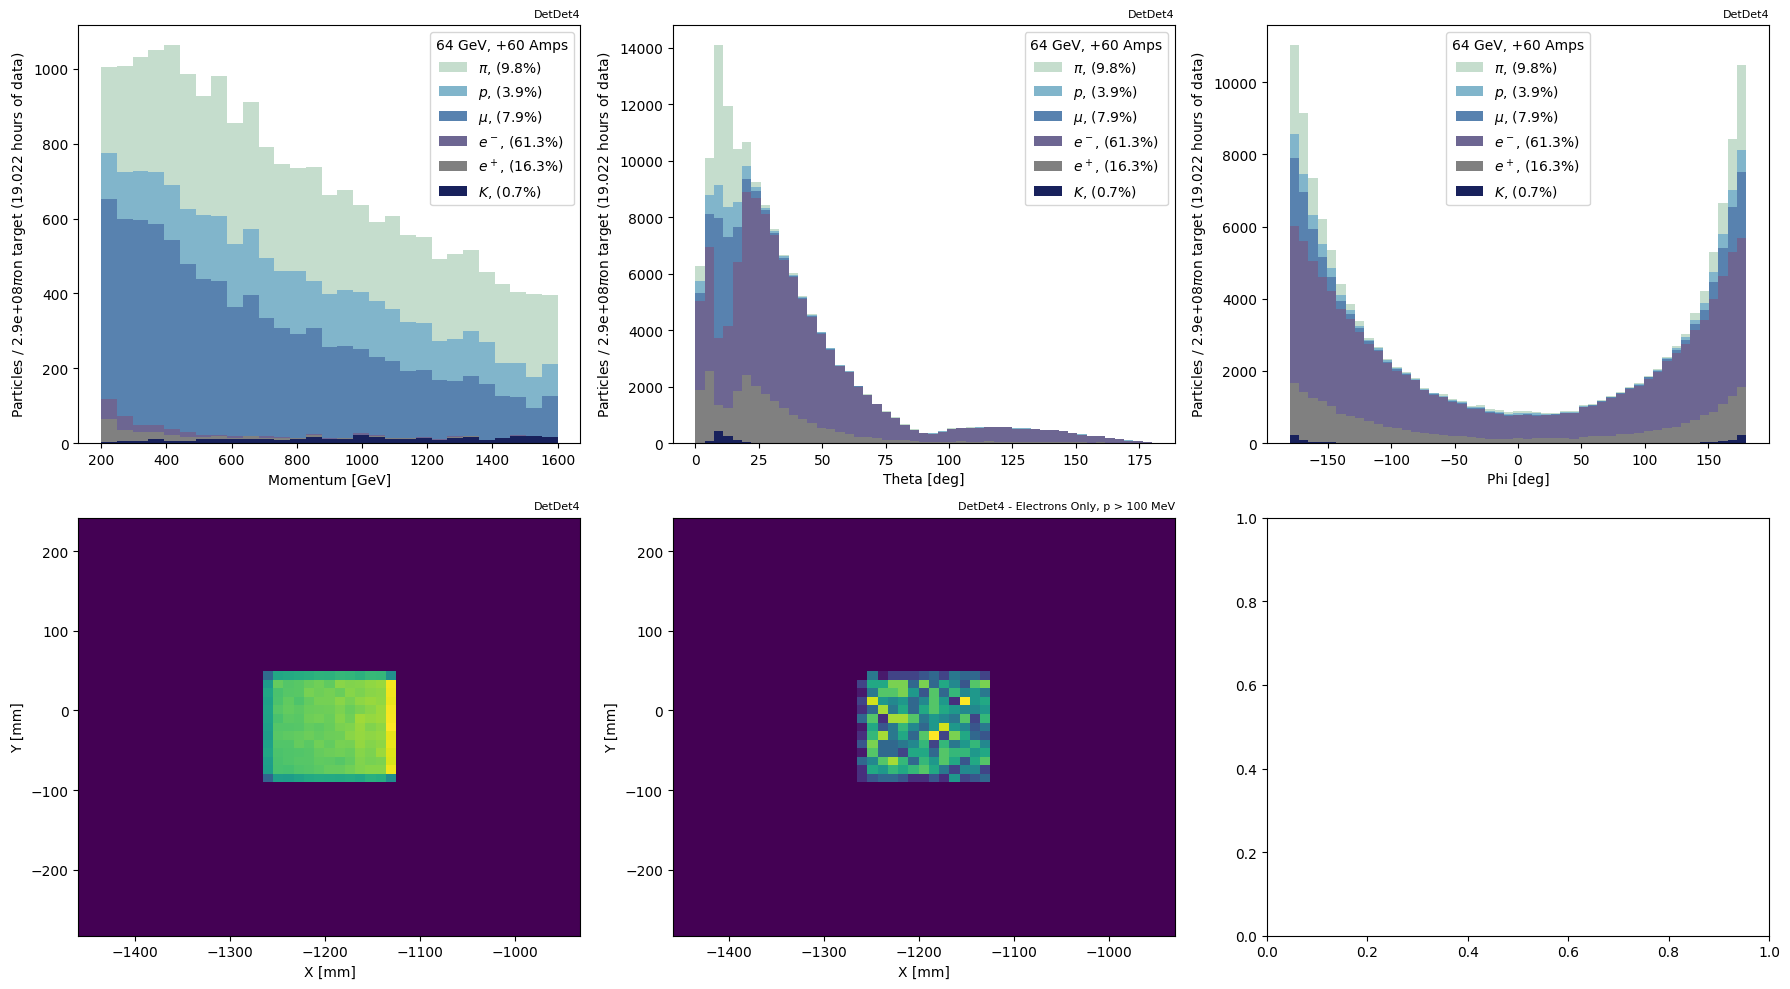

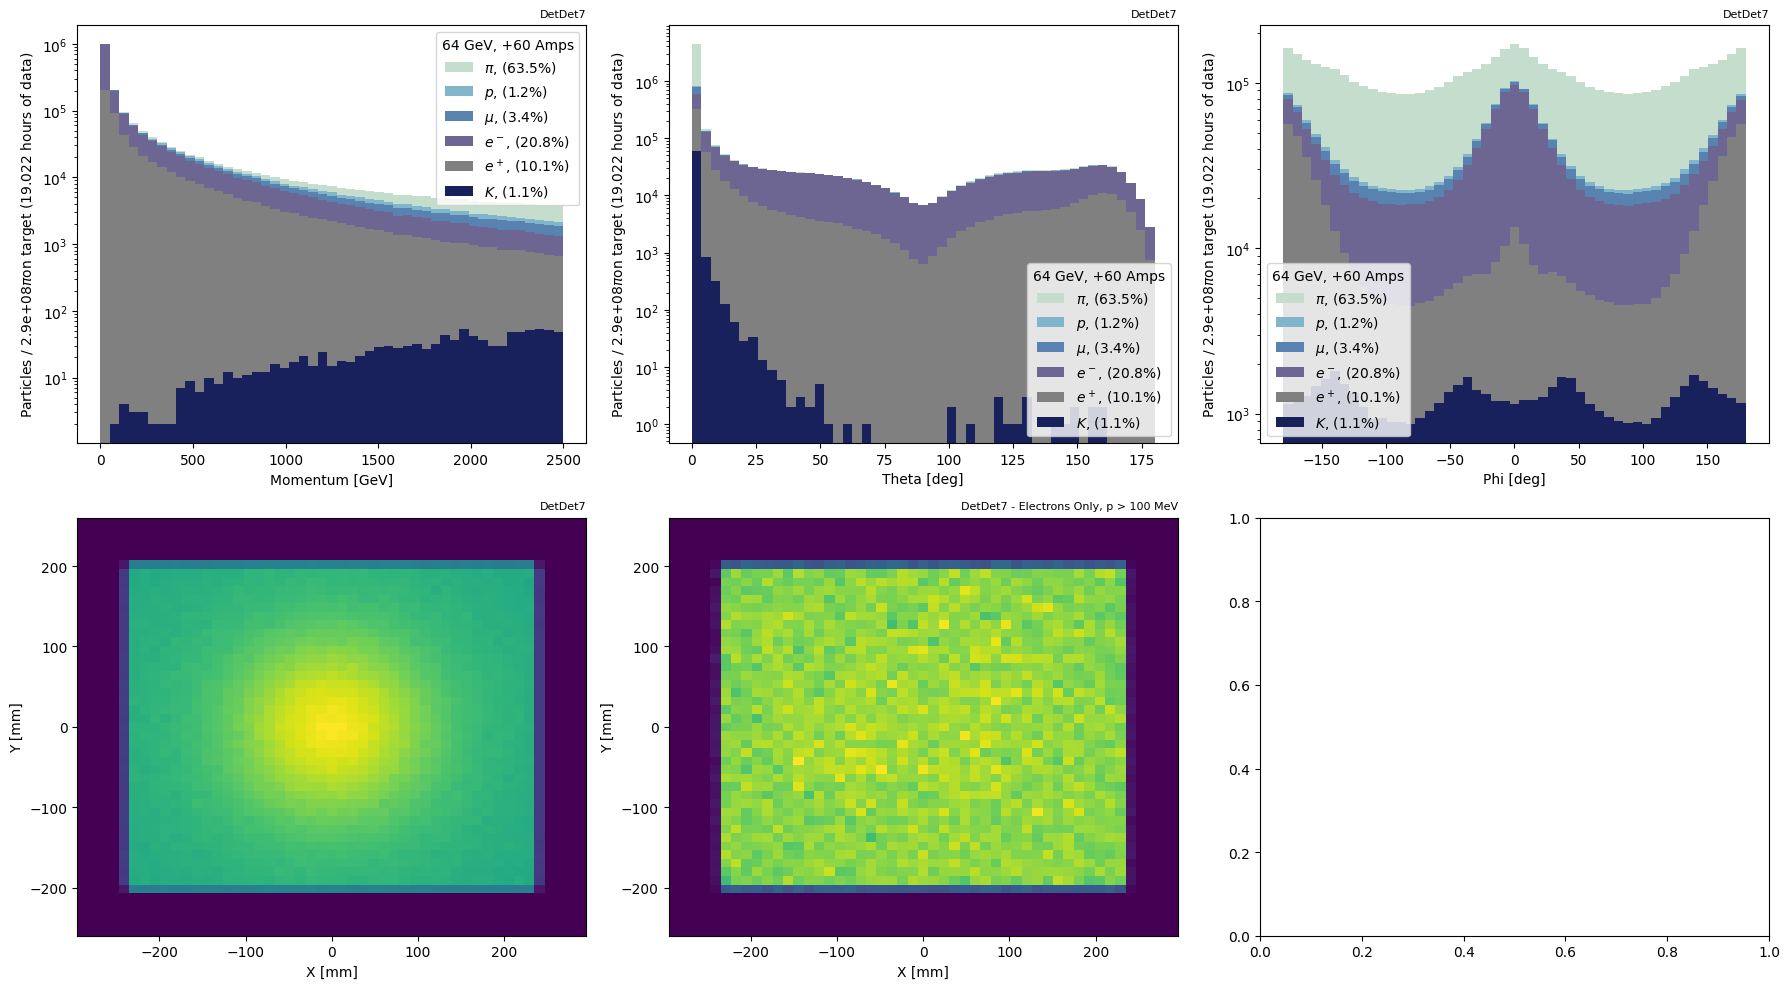

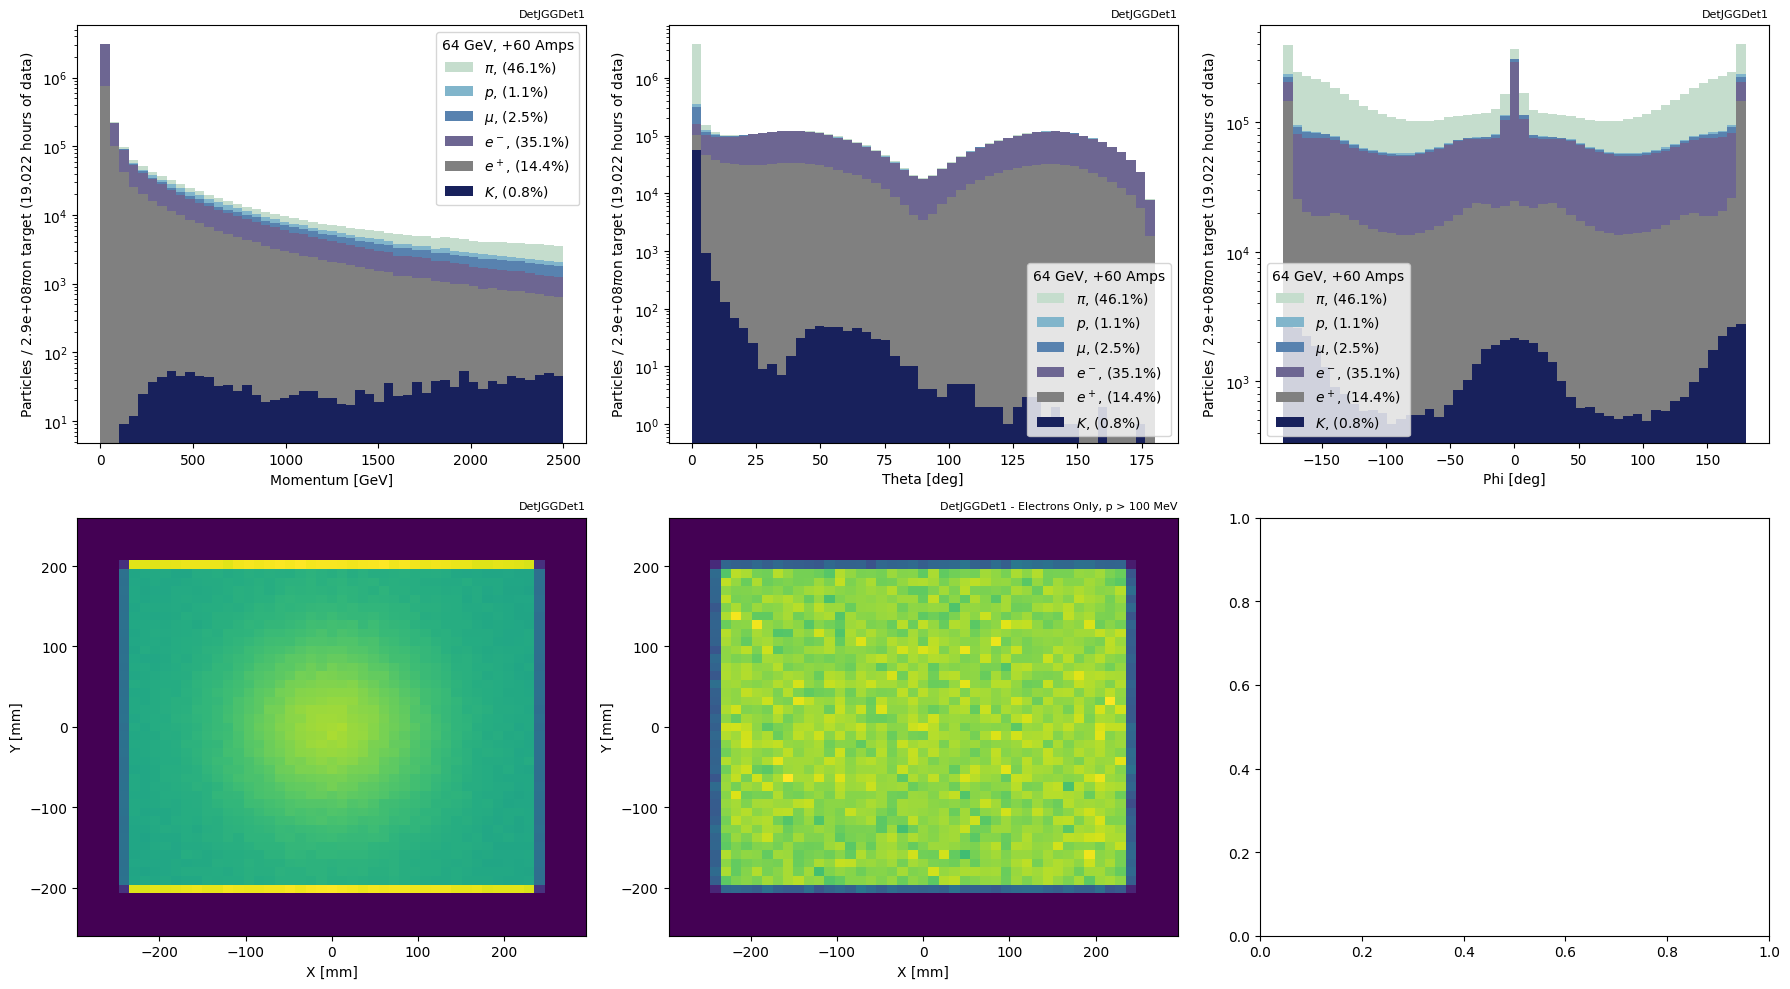

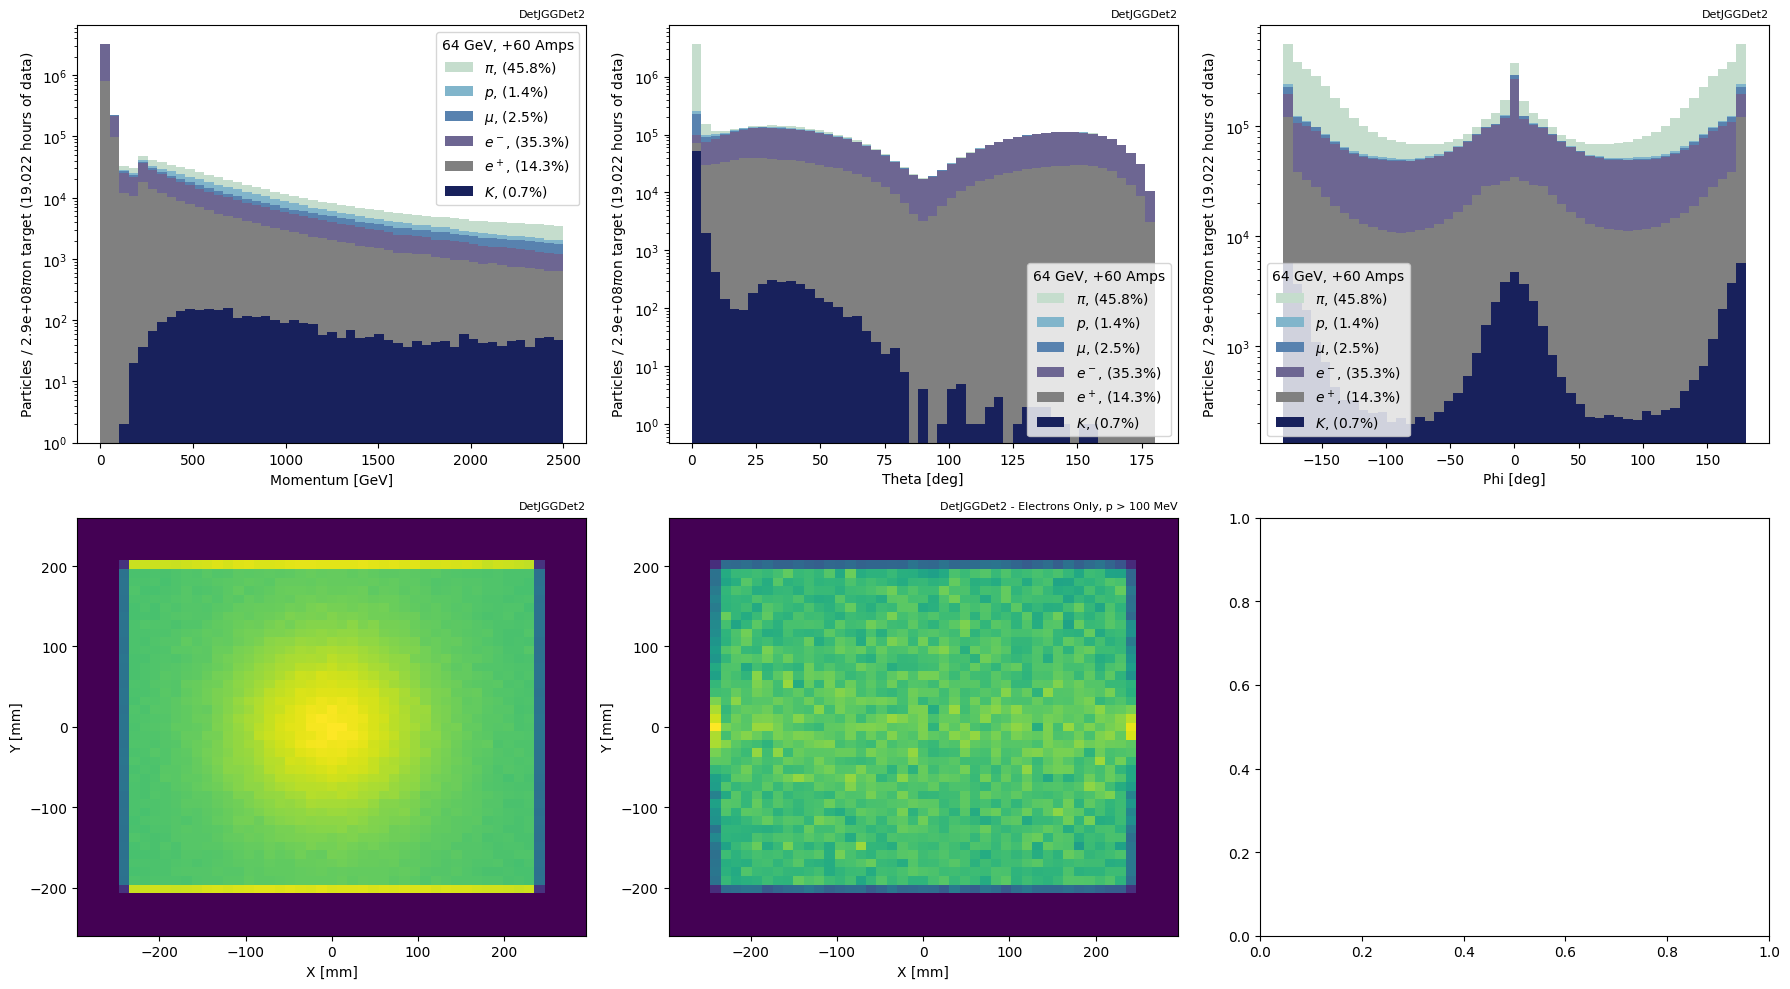

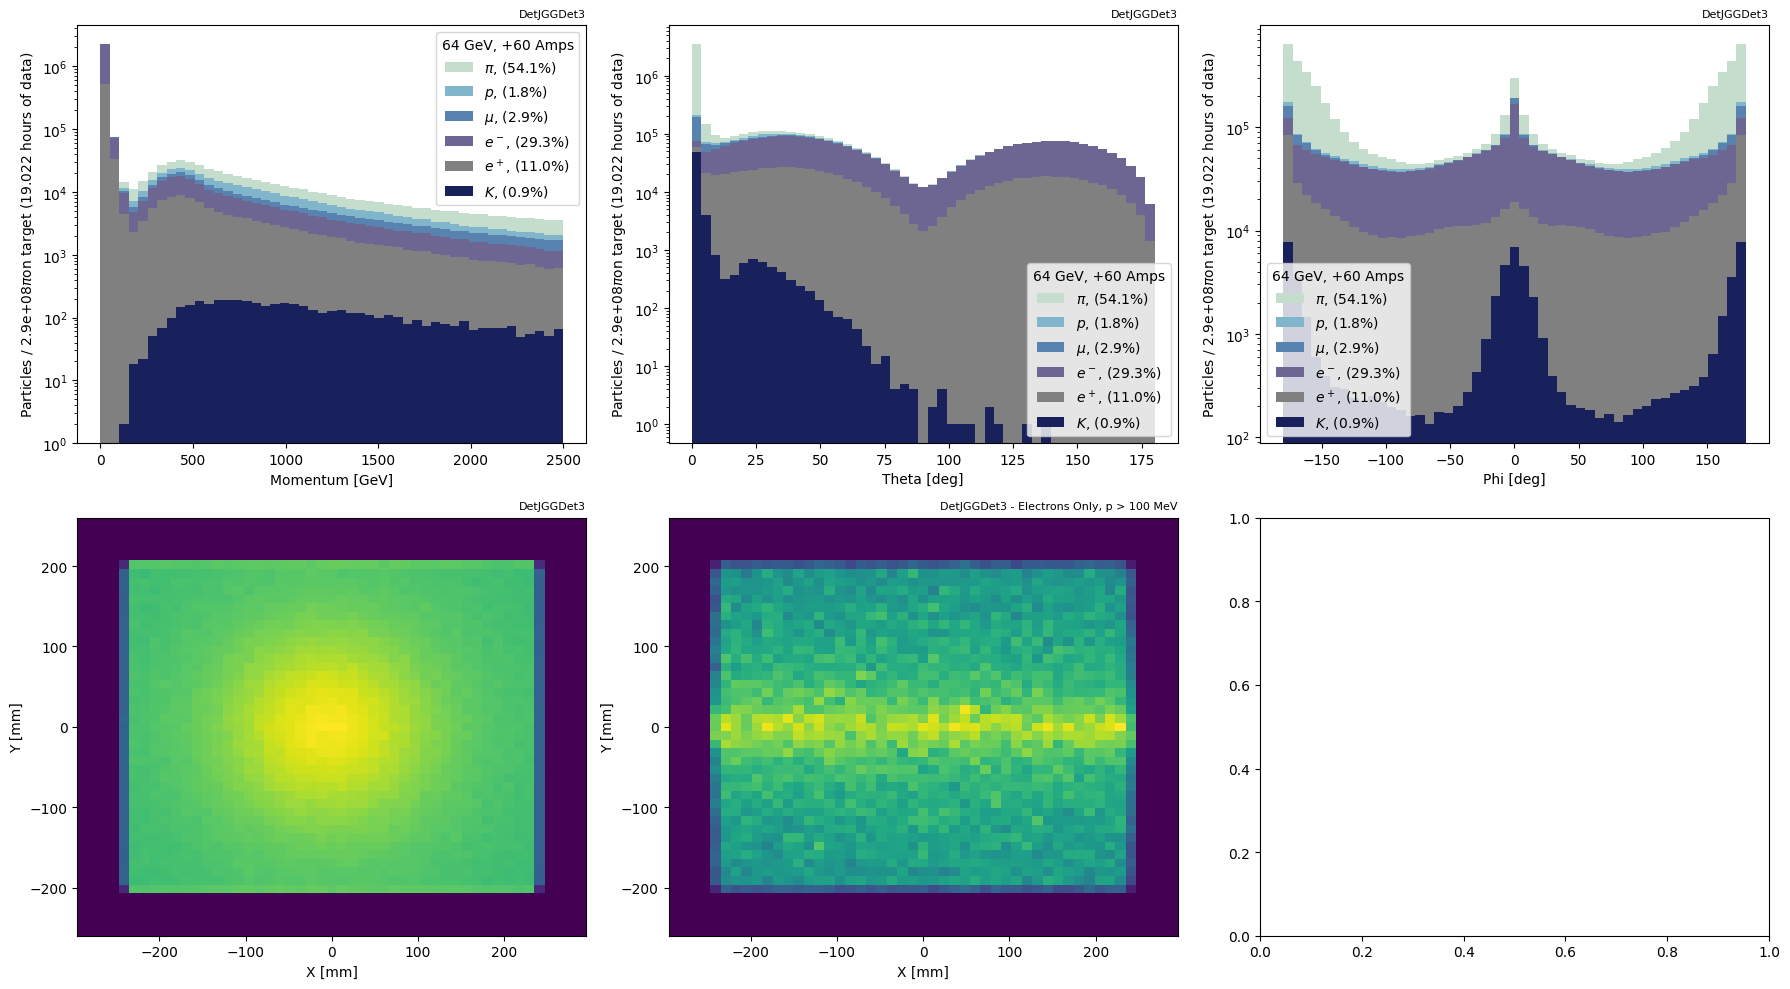

In [67]:
for det in ['Det4', 'Det7', 'JGGDet1', 'JGGDet2', 'JGGDet3']:

    if file[f'VirtualDetector/{det}'].num_entries == 0:
        print(f'No events for {det}')
        continue

    branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid']
    arrays = file[f'VirtualDetector/{det}'].arrays(branches)
    mask = arrays[f'PDGid'] != 0

    x = arrays['x'][mask]
    y = arrays['y'][mask]
    z = arrays['z'][mask]
    px = arrays['Px'][mask]
    py = arrays['Py'][mask]
    pz = arrays['Pz'][mask]
    pdg = arrays['PDGid'][mask]
    p = np.sqrt(px**2 + py**2 + pz**2)
    
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

    x_axis = ['Momentum [GeV]', 'Theta [deg]', 'Phi [deg]']
    x_bins = [np.linspace(0, 2500, 50),
              np.linspace(0, 180, 50),
              np.linspace(-180, 180, 50)]

    for i, var in enumerate([p, theta, phi]):
        
        kaons = var[np.abs(pdg)==321]
        positrons = var[pdg==-11]
        electrons = var[pdg==+11]
        muons = var[np.abs(pdg)==13]
        protons = var[np.abs(pdg)==2212]
        pions = var[np.abs(pdg)==211]
        others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
        gamma = var[np.abs(pdg)==22]
        
        values = [
            # p_others,
            # p_gamma,
            var[np.abs(pdg)==321],
            var[pdg==-11],
            var[pdg==11],
            var[np.abs(pdg)==13],
            var[np.abs(pdg)==2212],
            var[np.abs(pdg)==211],
        ]
    
        tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
        # tot += len(others)
        # tot += len(gamma)
        
        labels = [
            # 'others' + f', ({len(others) / tot * 100:.1f}%)',
            # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
            r'$K$' + f', ({len(kaons) / tot * 100:.1f}%)',
            r'$e^+$' + f', ({len(positrons) / tot * 100:.1f}%)',
            r'$e^-$' + f', ({len(electrons) / tot * 100:.1f}%)',
            r'$\mu$' + f', ({len(muons) / tot * 100:.1f}%)',
            r'$p$' + f', ({len(protons) / tot * 100:.1f}%)',
            r'$\pi$' + f', ({len(pions) / tot * 100:.1f}%)'
        ]
    
        bins = x_bins[i]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        
        ax[0][i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[0][i].legend()
        handles, labels = ax[0][i].get_legend_handles_labels()
        ax[0][i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[0][i].set_xlabel(x_axis[i])
        ax[0][i].set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        ax[0][i].set_title(f'Det{det}', loc='right', fontsize=8)
        
        if det == 'Det7' or det == 'Det8' or 'JGG' in det:
            ax[0][i].set_yscale('log')

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    if det == 'Det4':
        xbins = np.linspace(-64-1195.0827-200, 64-1195.0827+200, 50)
        ybins = np.linspace(-62.5-20.4724-200, 62.5-20.4724+200, 50)
    ax[1][0].hist2d(np.array(x), np.array(y), bins=[xbins, ybins])
    ax[1][0].set_xlabel('X [mm]')
    ax[1][0].set_ylabel('Y [mm]')
    ax[1][0].set_title(f'Det{det}', loc='right', fontsize=8)

    mask_e = np.abs(pdg) == 11
    ax[1][1].hist2d(np.array(x[mask_e]), np.array(y[mask_e]), bins=[xbins, ybins])
    ax[1][1].set_xlabel('X [mm]')
    ax[1][1].set_ylabel('Y [mm]')
    ax[1][1].set_title(f'Det{det} - Electrons Only', loc='right', fontsize=8)

    mask_p100 = p > 100
    ax[1][1].hist2d(np.array(x[mask_e & mask_p100]), np.array(y[mask_e & mask_p100]), bins=[xbins, ybins])
    ax[1][1].set_xlabel('X [mm]')
    ax[1][1].set_ylabel('Y [mm]')
    ax[1][1].set_title(f'Det{det} - Electrons Only, p > 100 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimple_{config}_det{det}.pdf')
    plt.show()


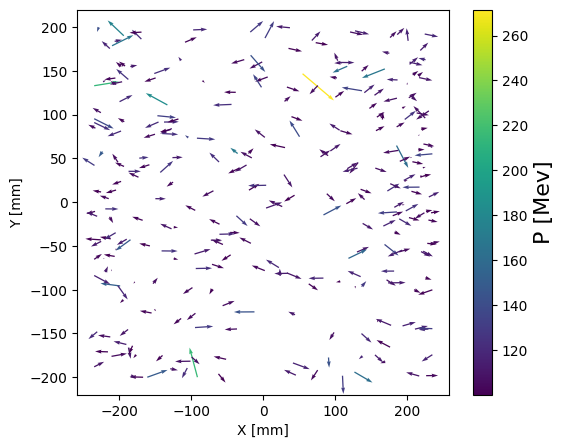

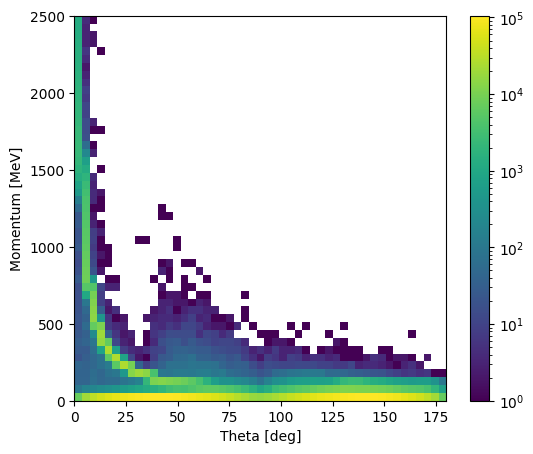

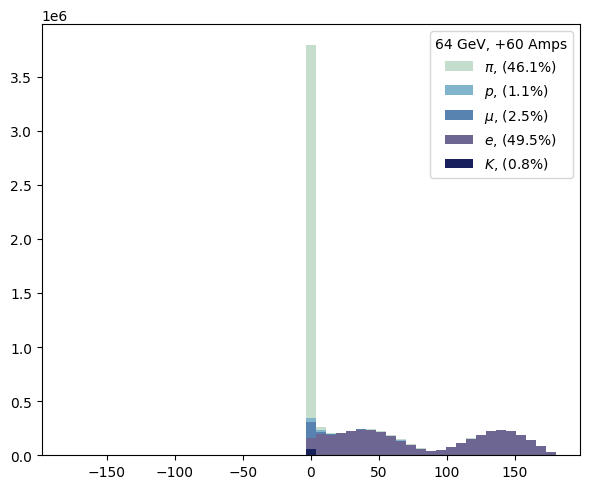

In [63]:
# for det in ['Det4', 'Det7', 'JGGDet1', 'JGGDet2', 'JGGDet3']:
for det in ['JGGDet1']:

    if file[f'VirtualDetector/{det}'].num_entries == 0:
        print(f'No events for {det}')
        continue

    branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid']
    arrays = file[f'VirtualDetector/{det}'].arrays(branches)
    mask = arrays[f'PDGid'] != 0

    x = arrays['x'][mask]
    y = arrays['y'][mask]
    z = arrays['z'][mask]
    px = arrays['Px'][mask]
    py = arrays['Py'][mask]
    pz = arrays['Pz'][mask]
    p = np.sqrt(px**2 + py**2 + pz**2)
    pdg = arrays[f'PDGid'][mask]

    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    x_axis = ['Theta [deg]']
    x_bins = [np.linspace(-180, 180, 50)]

    mask_e = np.abs(pdg) == 11
    mask_theta = theta > 100
    mask_p = (p > 100) & (p < 500)
    tot_mask = mask_e & mask_theta & mask_p
    n_entries = 300
    X = np.array(x[tot_mask])[:n_entries]
    Y = np.array(y[tot_mask])[:n_entries]
    U = np.array(px[tot_mask])[:n_entries]
    V = np.array(py[tot_mask])[:n_entries]
    M = np.array(p[tot_mask])[:n_entries]

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    q = ax.quiver(X, Y, U, V, M) #, alpha=0.1)
    cbar = fig.colorbar(q)
    cbar.ax.set_ylabel('P [Mev]', fontsize=16)

    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')

    plt.show()


    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    mask_p = (p > 100)
    tot_mask = mask_e # & mask_p
    
    h = ax.hist2d(np.array(theta[tot_mask]), np.array(p[tot_mask]),
                  bins=[np.linspace(0, 180, 50), np.linspace(0, 2500, 50)],
                  norm=mpl.colors.LogNorm())

    fig.colorbar(h[3], ax=ax)

    ax.set_xlabel('Theta [deg]')
    ax.set_ylabel('Momentum [MeV]')

    plt.show()


    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

    for i, var in enumerate([theta]):
        
        kaons = var[np.abs(pdg)==321]
        electrons = var[np.abs(pdg)==11]
        muons = var[np.abs(pdg)==13]
        protons = var[np.abs(pdg)==2212]
        pions = var[np.abs(pdg)==211]
        others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
        gamma = var[np.abs(pdg)==22]
        
        values = [
            # p_others,
            # p_gamma,
            var[np.abs(pdg)==321],
            var[np.abs(pdg)==11],
            var[np.abs(pdg)==13],
            var[np.abs(pdg)==2212],
            var[np.abs(pdg)==211],
        ]
    
        tot = len(kaons) + len(electrons) + len(muons) + len(protons) + len(pions)
        # tot += len(others)
        # tot += len(gamma)
        
        labels = [
            # 'others' + f', ({len(others) / tot * 100:.1f}%)',
            # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
            r'$K$' + f', ({len(kaons) / tot * 100:.1f}%)',
            r'$e$' + f', ({len(electrons) / tot * 100:.1f}%)',
            r'$\mu$' + f', ({len(muons) / tot * 100:.1f}%)',
            r'$p$' + f', ({len(protons) / tot * 100:.1f}%)',
            r'$\pi$' + f', ({len(pions) / tot * 100:.1f}%)'
        ]
    
        bins = x_bins[i]
        if det == 'Det4' and i == 0:
            bins = np.linspace(200, 1600, 30)
        if det == 'Det5' and i == 0:
            bins = np.linspace(150, 2500, 50)
        
        ax.hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        # ax.set_xlabel(x_axis[i])
        # ax.set_ylabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)' )
        # ax.set_title(f'Det{det}', loc='right', fontsize=8)
        

    xbins = np.linspace(-235-60, 235+60, 50)
    ybins = np.linspace(-200-60, 200+60, 50)
    # if det == 'Det4':
    #     xbins = np.linspace(-64-1195.0827-200, 64-1195.0827+200, 50)
    #     ybins = np.linspace(-62.5-20.4724-200, 62.5-20.4724+200, 50)
    # ax[1][0].hist2d(np.array(x), np.array(y), bins=[xbins, ybins])
    # ax[1][0].set_xlabel('X [mm]')
    # ax[1][0].set_ylabel('Y [mm]')
    # ax[1][0].set_title(f'Det{det}', loc='right', fontsize=8)

    # mask_e = np.abs(pdg) == 11
    # ax[1][1].hist2d(np.array(x[mask_e]), np.array(y[mask_e]), bins=[xbins, ybins])
    # ax[1][1].set_xlabel('X [mm]')
    # ax[1][1].set_ylabel('Y [mm]')
    # ax[1][1].set_title(f'Det{det} - Electrons Only', loc='right', fontsize=8)

    # mask_p100 = p > 100
    # ax[1][1].hist2d(np.array(x[mask_e & mask_p100]), np.array(y[mask_e & mask_p100]), bins=[xbins, ybins])
    # ax[1][1].set_xlabel('X [mm]')
    # ax[1][1].set_ylabel('Y [mm]')
    # ax[1][1].set_title(f'Det{det} - Electrons Only, p > 100 MeV', loc='right', fontsize=8)
    
    plt.tight_layout()
    # plt.savefig(_save_dir + f'spectra_g4blsimple_{config}_det{det}.pdf')
    plt.show()


In [15]:

file = uproot.open('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05/files/sim_arcs_beamline_9.root')
file.keys()
# file['VirtualDetector/Det7'].keys()

['VirtualDetector;1',
 'VirtualDetector/StartLine;1',
 'VirtualDetector/TOFus;1',
 'VirtualDetector/Det1;1',
 'VirtualDetector/Det2;1',
 'VirtualDetector/Det3;1',
 'VirtualDetector/Det4;1',
 'VirtualDetector/TOFds;1',
 'VirtualDetector/Det5;1',
 'VirtualDetector/Det6;1',
 'VirtualDetector/Det7;1',
 'VirtualDetector/Det8;1']

In [8]:
# files = glob('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/18jun2024/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_*.root')
# print('Number of files:', len(files))

files = [' /pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/21june2024/files/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9.root']

In [9]:
for f in files:
    print('At file', f)
    file = uproot.open(f)
    name = file.keys()[0]
    arrays = file[name].arrays()
    
    with uproot.recreate('temp.root') as output_file:
    
        for det_no in [1, 2, 3, 4, 5, 6, 7]:
    
            mask = arrays[f'TrackPresentDet{det_no}'] == True
            output_file[f'EventsDet{det_no}'] = arrays[mask]

    out_file_name = f[:-5] + '_reprocessed.root'
    os.system(f'mv temp.root {out_file_name}')


At file  /pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/21june2024/files/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9.root


In [12]:
with uproot.recreate("test.root") as output_file:
    output_file["EventsDet4"] = arrays

In [17]:
file = uproot.open('test.root')
file.keys()

['EventsDet1;1',
 'EventsDet2;1',
 'EventsDet3;1',
 'EventsDet4;1',
 'EventsDet5;1',
 'EventsDet6;1',
 'EventsDet7;1']

In [3]:
histos = []
bins = np.linspace(0, 3000, 50)

for i, file in enumerate(files):
    file = uproot.open(file)
    name = file.keys()[0][:-2]
    print(i, name)
    arrays = file[name].arrays()

    mask = arrays['TrackPresentDet4'] == True

    px = arrays['PxDet4'][mask]
    py = arrays['PyDet4'][mask]
    pz = arrays['PzDet4'][mask]
    p = np.sqrt(px**2 + py**2 + pz**2)
    pdg = arrays['PDGidDet4'][mask]

    h, _ = np.histogram(p, bins)
    histos.append(ak.to_numpy(h))

    if i > 10: break

0 EventTree_Spill241
1 EventTree_Spill371
2 EventTree_Spill36
3 EventTree_Spill170
4 EventTree_Spill603
5 EventTree_Spill364
6 EventTree_Spill65
7 EventTree_Spill229
8 EventTree_Spill57
9 EventTree_Spill469
10 EventTree_Spill31
11 EventTree_Spill61


In [4]:
histo_merged = histos[0]
for i in range(1, len(histos)):
    histo_merged = np.add(histo_merged, histos[i])

histo_merged

array([45.,  0.,  1.,  6.,  7.,  8.,  6.,  8.,  7.,  5.,  7.,  2.,  2.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

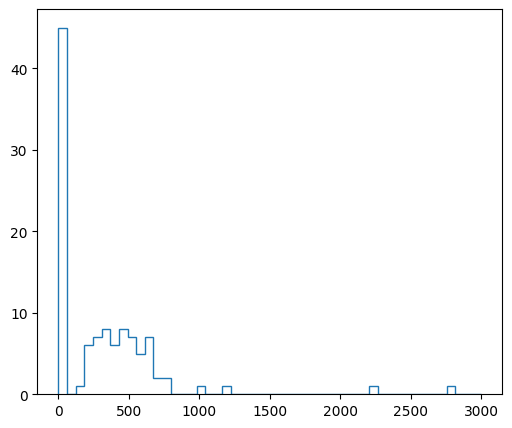

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

ax.stairs(histo_merged, bins, label='Simple histogram')

In [68]:
trees = file.keys()
trees

['EventTree_Spill1059;1']

In [61]:
# file['EventTree_Spill1'].keys()

In [65]:
for tree in trees:

    tree_name = tree[:-2]
    print(tree_name)
    break

EventTree_Spill117


In [5]:
arrays = file['EventTree_Spill1'].arrays()

KeyInFileError: not found: 'EventTree_Spill1' (with any cycle number)

    Available keys: 'EventTree_Spill1059;1'

in file /pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/18jun2024/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9070.root

In [54]:
len(arrays)

439148

In [47]:
np.sum(arrays['TrackPresentDet4'])

np.int64(12)

In [48]:
mask = arrays['TrackPresentDet4'] == True

px = arrays['PxDet4'][mask]
py = arrays['PyDet4'][mask]
pz = arrays['PzDet4'][mask]
p = np.sqrt(px**2 + py**2 + pz**2)
pdg = arrays['PDGidDet4'][mask]

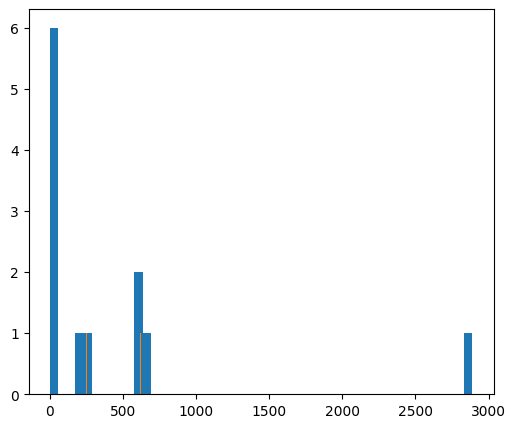

In [49]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

ax.hist(p, bins=50)
ax.hist(p[pdg==211], bins=50)

plt.show()